In [ ]:
# plot storm-induced impact on NPP
# Fig. S10 in paper

In [1]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, MFDataset
import numba as nb
import time as timing
from numba import njit 
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
import seawater as sw
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [2]:
#---
# CHOOSE YEARS to plot
#---

years = np.arange(1997,2018+1,1) 

#---
# SAVEPATH
#---

#---
# where to save plots?
#---
savepath     = '/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/'+\
                    'storm_anomalies_vs_deviations_from_clim/FIXED_DUPLICATES_v2/'
# check existence of paths
if not os.path.exists(savepath):
    print ('Created '+savepath)
    os.makedirs(savepath)
    
savepath2     = savepath+'eps/'
# check existence of paths
if not os.path.exists(savepath2):
    print ('Created '+savepath2)
    os.makedirs(savepath2)
    
dpicnt = 150
save_plots    = True
display_plots = True


In [3]:
#---
# FUNCTION 
#---

def get_distance_to_storm_center(lat2,lon2,aux_lat,aux_lon):
                
    # create list of locations within 1000km of the storm
    points_data = []
    for pp in range(0,lat2.shape[0]):
        aux = (lat2[pp],lon2[pp])
        points_data.append(aux)
        del aux

    #print(len(points_data))
    # for each of these points get the distance to the storm center in km -> get distance in x-dir and y-dir
    points_distance_x = np.zeros(len(points_data)) # distance in longitudinal direction, i.e., use latitude of storm (aux_lat)
    points_distance_y = np.zeros(len(points_data)) # distance in latitudinal direction, i.e., use longitude of storm (aux_lon)
    for pp in range(0,len(points_data)): 
        # distance in longitudinal direction
        aux_point = (aux_lat,points_data[pp][1])
        points_distance_x[pp] = distance(point_storm, aux_point).km
       # print(aux_point,point_storm,points_distance_x[pp])
        # check sign: if lon grid cell is smaller (=further west) than lon of storm, define distance to be negative
        if points_data[pp][1]<aux_lon:
            points_distance_x[pp] = -1*points_distance_x[pp]
        elif (aux_lon<0) & (points_data[pp][1]>0): # lon_storm is east of dateline, but grid cell is west of dateline (grid cell is also further west in this case!)
            if (points_data[pp][1]-360)<aux_lon:
                points_distance_x[pp] = -1*points_distance_x[pp]
        del aux_point
        # distance in latitudinal direction
        aux_point = (points_data[pp][0],aux_lon)
        points_distance_y[pp] = distance(point_storm, aux_point).km
        # check sign: if lat grid cell is smaller (=further south) than lat of storm, define distance to be negative
        if points_data[pp][0]<aux_lat:
            points_distance_y[pp] = -1*points_distance_y[pp]
        del aux_point  
    return points_distance_x,points_distance_y,points_data
                    
    
def bin_points_as_distance_to_storm_center(counter,points_distance_x,points_distance_y,x_bins,y_bins,aux_data_anom,data_storm_mean,data_storm_std,data_storm_count):
    # data_storm_mean,data_storm_std,data_storm_count: initialized arrays, will be filled in this function and then returned
    
    # bin the points (account for where each point is relative to storm center)
    ind_x = np.digitize(points_distance_x,x_bins,right=False) # minimum is 1 (not zero!!)
    ind_y = np.digitize(points_distance_y,y_bins,right=False)
 #   print(np.min(ind_x),np.max(ind_x))
 #   print(np.min(ind_y),np.max(ind_y))
    # returned index satisfies: bins[i-1] <= x < bins[i]

   # print(aux_data_anom.shape)
    for xx in range(1,len(x_bins)+1): # start at 1 here -> see note above for ind_x
        for yy in range(1,len(x_bins)+1):
            index = np.where((ind_y==yy) & (ind_x==xx))[0]
            if len(index)>0:
                #if counter==6: 
                #    print(xx,yy,index.shape,aux_data_anom.shape)
                #if (counter==40) & (xx==11) & (yy==20):
                #    print(xx,yy,len(points_distance_x))
                #    print(index)
                #    print(index.shape,aux_data_anom.shape)
                # anomaly 2
                data_storm_mean[xx-1,yy-1]  = np.nanmean(aux_data_anom[index])
                data_storm_std[xx-1,yy-1]   = np.nanstd(aux_data_anom[index])
                data_storm_count[xx-1,yy-1] = index.shape[0]
            del index
    return data_storm_mean,data_storm_std,data_storm_count
    

In [6]:
#---
# LOAD COMPOSITES for totChl (low res/full, low res/emulator, high res)
#---

def get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,ratio_median,ratio_median_monthly):
    
    # get the median ratio for each year
    counter = 0
    for ss in range(0,data_storm_aux.shape[0]):
        aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
        if not np.isnan(aux_field):
            ratio_median[yy] = ratio_median[yy] + aux_field
            counter = counter+1
    ratio_median[yy] = np.divide(ratio_median[yy],counter)
    
    # get the median ratio for each year, EACH MONTH
    for mm in range(0,12):
        ind_mm = np.where(month_storm_aux==mm+1)[0]
        counter = 0
        for ss in ind_mm: 
            aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
            if not np.isnan(aux_field):
                ratio_median_monthly[yy,mm] = ratio_median_monthly[yy,mm] + aux_field
                counter = counter+1
        ratio_median_monthly[yy,mm] = np.divide(ratio_median_monthly[yy,mm],counter)
        
    return ratio_median,ratio_median_monthly

def grow_arrays(yy,year_list,data_storm_aux,data_dev_aux,month_storm_aux,lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux,\
                                                           data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm): 
    if yy==0:
        data_storm  = data_storm_aux
        data_dev    = data_dev_aux
        month_storm = month_storm_aux
        lat_storm   = lat_storm_aux
        lon_storm   = lon_storm_aux
        slp_min_storm   = slp_min_storm_aux
        slp_avg_storm   = slp_avg_storm_aux
        year_storm = year_list[yy]*np.ones(data_storm_aux.shape[0])
    else:
        data_storm  = np.concatenate((data_storm,data_storm_aux))
        data_dev    = np.concatenate((data_dev,data_dev_aux))
        month_storm = np.concatenate((month_storm,month_storm_aux))
        lat_storm   = np.concatenate((lat_storm,lat_storm_aux))
        lon_storm   = np.concatenate((lon_storm,lon_storm_aux))
        slp_min_storm   = np.concatenate((slp_min_storm,slp_min_storm_aux))
        slp_avg_storm   = np.concatenate((slp_avg_storm,slp_avg_storm_aux))
        year_storm  = np.concatenate((year_storm,year_list[yy]*np.ones(data_storm_aux.shape[0])))
                
    return data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm

def load_data(path1a,path1b,file1,file3,vari1a,vari1b): 
    # storm-induced anomaly
    ff  = xr.open_dataset(path1a+file1)
    data_storm_aux  = ff[vari1a+'_storm_anomaly4_mean'].values 
    month_storm_aux = ff['month_storm'].values  # at min. SLP
    day_storm_aux   = ff['day_storm'].values  # at min. SLP
    year_storm_aux  = ff['year_storm'].values  # at min. SLP
    lat_storm_aux   = ff['lat_storm'].values  # at min. SLP
    lon_storm_aux   = ff['lon_storm'].values  # at min. SLP
    slp_avg_storm_aux   = ff['avg_min_slp_storm'].values  # avg of all min SLP over all time steps of the storm's existence 
    slp_min_storm_aux   = ff['min_min_slp_storm'].values  # min. SLP over all time steps of the storm's existence 
    ff.close()
    data_storm_aux[data_storm_aux==0] = np.nan
    
    # deviations from climatology
    ff  = xr.open_dataset(path1b+file3)
    data_dev_aux = ff[vari1b+'_storm_anomaly4_mean'].values 
    ff.close()
    data_dev_aux[data_dev_aux==0] = np.nan
    
    return data_storm_aux,day_storm_aux,month_storm_aux,year_storm_aux,\
                lat_storm_aux,lon_storm_aux,data_dev_aux,slp_avg_storm_aux,slp_min_storm_aux
    

year_list = np.arange(1997,2018+1,1)

vari = 'totChl'
path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'
path2 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_emulator_anomalies/'
path3 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_hr_anomalies/'
    
# what's the median ratio between storm-induced anomalies and deviations from clim?
ratio_median            = np.zeros([len(year_list)]) 
ratio_median_monthly    = np.zeros([len(year_list),12])
ratio_median_em         = np.zeros([len(year_list)]) 
ratio_median_monthly_em = np.zeros([len(year_list),12])
ratio_median_hr         = np.zeros([len(year_list)]) 
ratio_median_monthly_hr = np.zeros([len(year_list),12])
# initilize variables (will be overwritten!)
#data_storm,data_dev,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm,year_storm = [],[],[],[],[],[],[],[]
#data_storm_em,data_dev_em,month_storm_em,lat_storm_em,lon_storm_em,slp_avg_storm_em,slp_min_storm_em,year_storm_em = [],[],[],[],[],[],[],[]
#data_storm_hr,data_dev_hr,month_storm_hr,lat_storm_hr,lon_storm_hr,slp_avg_storm_hr,slp_min_storm_hr,year_storm_hr = [],[],[],[],[],[],[],[]

#----
# LOW RES, FULL FIELD
#----
    
# storm-induced anomaly
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'

# load data
data_storm,day_storm,month_storm,year_storm,lat_storm,lon_storm,\
            data_dev,slp_avg_storm,slp_min_storm = load_data(path1,path1,file1,file3,vari,vari)
    
## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
#ratio_median,ratio_median_monthly = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
#                                                         ratio_median,ratio_median_monthly)
        
#----
# LOW RES, EMULATOR
#----
    
# storm-induced anomaly
#file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
#            str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
            str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc' # in TEST folder, this is the file using the full-field clim
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc' # uses full-field clim

# storm-induced anomaly


# load data
data_storm_em,day_storm_em,month_storm_em,year_storm_em,lat_storm_em,lon_storm_em,\
            data_dev_em,slp_avg_storm_em,slp_min_storm_em = load_data(path2+'TEST/',path1,file1,file3,vari+'_emulator',vari)
    
## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
#ratio_median_em,ratio_median_monthly_em = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
#                                                         ratio_median_em,ratio_median_monthly_em)
    
    
    
plot_hr = False
if plot_hr:
    #----
    # HIGH RES, FULL FIELD
    #----

    # storm-induced anomaly
    file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
    # deviations from climatology
    file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'

    # load data
    data_storm_hr,day_storm_hr,month_storm_hr,year_storm_hr,lat_storm_hr,lon_storm_hr,\
                data_dev_hr,slp_avg_storm_hr,slp_min_storm_hr = load_data(path3,path3,file1,file3,vari,vari)

    ## get median ratio for each year (& month) individually (--> look at variability of median across years/months!)
    #ratio_median_hr,ratio_median_monthly_hr = get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,\
    #                                                     ratio_median_hr,ratio_median_monthly_hr)

    print(data_storm_hr.shape,data_dev_hr.shape)
    
print(data_storm.shape,data_dev.shape)
print(data_storm_em.shape,data_dev_em.shape)



#----
# make sure that the same storms are considered in LOW RES and HIGH RES
#----

data_aux_mean = np.nanmean(np.nanmean(data_storm,axis=2),axis=1)
ind_no_NaN = np.where(~np.isnan(data_aux_mean))[0]
ind_no_NaN_lr = np.copy(ind_no_NaN) # for wind speeds further down

data_storm     = data_storm[ind_no_NaN,:,:]
data_storm_em  = data_storm_em[ind_no_NaN,:,:]
if plot_hr:
    data_storm_hr  = data_storm_hr[ind_no_NaN,:,:]
data_dev     = data_dev[ind_no_NaN,:,:]
data_dev_em  = data_dev_em[ind_no_NaN,:,:]
if plot_hr:
    data_dev_hr  = data_dev_hr[ind_no_NaN,:,:]

month_storm = month_storm[ind_no_NaN]
year_storm  = year_storm[ind_no_NaN]
lat_storm   = lat_storm[ind_no_NaN]
lon_storm   = lon_storm[ind_no_NaN]
slp_avg_storm = slp_avg_storm[ind_no_NaN]
slp_min_storm = slp_min_storm[ind_no_NaN]

if plot_hr:
    month_storm_hr = month_storm_hr[ind_no_NaN]
    year_storm_hr  = year_storm_hr[ind_no_NaN]
    lat_storm_hr   = lat_storm_hr[ind_no_NaN]
    lon_storm_hr   = lon_storm_hr[ind_no_NaN]
    slp_avg_storm_hr = slp_avg_storm_hr[ind_no_NaN]
    slp_min_storm_hr = slp_min_storm_hr[ind_no_NaN]

month_storm_em = month_storm_em[ind_no_NaN]
year_storm_em  = year_storm_em[ind_no_NaN]
lat_storm_em   = lat_storm_em[ind_no_NaN]
lon_storm_em   = lon_storm_em[ind_no_NaN]
slp_avg_storm_em = slp_avg_storm_em[ind_no_NaN]
slp_min_storm_em = slp_min_storm_em[ind_no_NaN]

print('data_storm_em.shape',data_storm_em.shape)
if plot_hr:
    print('data_storm_hr.shape',data_storm_hr.shape)
print('data_storm.shape',data_storm.shape)


(9615, 21, 21) (9615, 21, 21)
(9615, 21, 21) (9615, 21, 21)
data_storm_em.shape (9554, 21, 21)
data_storm.shape (9554, 21, 21)


/tmp/ipykernel_89017/2890193425.py:172: RuntimeWarning: Mean of empty slice
  data_aux_mean = np.nanmean(np.nanmean(data_storm,axis=2),axis=1)


In [7]:
#---
# load integrated NPP
#---

vari = 'photoC_zint'
path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'

#----
# LOW RES, FULL FIELD
#----
    
#----
# DAY OF STORM PASSING
#----
# storm-induced anomaly
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'
# load data
data_storm_npp,day_storm_npp,month_storm_npp,year_storm_npp,lat_storm_npp,lon_storm_npp,\
            data_dev_npp,slp_avg_storm_npp,slp_min_storm_npp = load_data(path1,path1,file1,file3,vari,vari)

ff  = xr.open_dataset(path1+file1)
days_storm_npp = ff['days_storm'].values  
ff.close()

#----
# +1 days
#----
# storm-induced anomaly
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_plus_1_days_subtract_clim_first.nc'
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'
# load data
data_storm_npp_plus_1,day_storm_npp,month_storm_npp,year_storm_npp,lat_storm_npp,lon_storm_npp,\
            data_dev_npp_plus_1,slp_avg_storm_npp,slp_min_storm_npp = load_data(path1,path1,file1,file3,vari,vari)

#----
# +2 days
#----
# storm-induced anomaly
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_plus_2_days_subtract_clim_first.nc'
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'
# load data
data_storm_npp_plus_2,day_storm_npp,month_storm_npp,year_storm_npp,lat_storm_npp,lon_storm_npp,\
            data_dev_npp_plus_2,slp_avg_storm_npp,slp_min_storm_npp = load_data(path1,path1,file1,file3,vari,vari)

#----
# +3 days
#----
# storm-induced anomaly
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_plus_3_days_subtract_clim_first.nc'
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'
# load data
data_storm_npp_plus_3,day_storm_npp,month_storm_npp,year_storm_npp,lat_storm_npp,lon_storm_npp,\
            data_dev_npp_plus_3,slp_avg_storm_npp,slp_min_storm_npp = load_data(path1,path1,file1,file3,vari,vari)


#----
# +4 days
#----
# storm-induced anomaly
file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_plus_4_days_subtract_clim_first.nc'
# deviations from climatology
file3 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_only.nc'
# load data
data_storm_npp_plus_4,day_storm_npp,month_storm_npp,year_storm_npp,lat_storm_npp,lon_storm_npp,\
            data_dev_npp_plus_4,slp_avg_storm_npp,slp_min_storm_npp = load_data(path1,path1,file1,file3,vari,vari)



# npp
data_storm_npp        = data_storm_npp[ind_no_NaN,:,:]
data_storm_npp_plus_1 = data_storm_npp_plus_1[ind_no_NaN,:,:]
data_storm_npp_plus_2 = data_storm_npp_plus_2[ind_no_NaN,:,:]
data_storm_npp_plus_3 = data_storm_npp_plus_3[ind_no_NaN,:,:]
data_storm_npp_plus_4 = data_storm_npp_plus_4[ind_no_NaN[:-1],:,:]
days_storm_npp = days_storm_npp[ind_no_NaN]
# deviations from clim
data_dev_npp        = data_dev_npp[ind_no_NaN,:,:]
data_dev_npp_plus_1 = data_dev_npp_plus_1[ind_no_NaN,:,:]
data_dev_npp_plus_2 = data_dev_npp_plus_2[ind_no_NaN,:,:]
data_dev_npp_plus_3 = data_dev_npp_plus_3[ind_no_NaN,:,:]
data_dev_npp_plus_4 = data_dev_npp_plus_4[ind_no_NaN[:-1],:,:]

print('data_storm_npp.shape',data_storm_npp.shape,data_dev_npp.shape)
print('data_storm_npp_plus_1.shape',data_storm_npp_plus_1.shape)
print('data_storm_npp_plus_2.shape',data_storm_npp_plus_2.shape)
print('data_storm_npp_plus_3.shape',data_storm_npp_plus_3.shape)
print('data_storm_npp_plus_4.shape',data_storm_npp_plus_4.shape)


data_storm_npp.shape (9554, 21, 21) (9554, 21, 21)
data_storm_npp_plus_1.shape (9554, 21, 21)
data_storm_npp_plus_2.shape (9554, 21, 21)
data_storm_npp_plus_3.shape (9554, 21, 21)
data_storm_npp_plus_4.shape (9553, 21, 21)


In [8]:
#---
# load absolute NPP
#---
def load_data2(path1a,file1,vari1a): 
    # storm-induced anomaly
    ff  = xr.open_dataset(path1a+file1)
    data_storm_aux  = ff[vari1a+'_storm_mean'].values 
    ff.close()
    data_storm_aux[data_storm_aux==0] = np.nan
    
    return data_storm_aux


vari = 'photoC_zint'
path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'

#----
# DAY OF STORM PASSING
#----
# storm-induced anomaly
file1 = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_subtract_clim_first.nc'
# load data
data_storm_npp_abs = load_data2(path1,file1,vari)

#----
# +1 days
#----
# storm-induced anomaly
file1 = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_plus_1_days_subtract_clim_first.nc'
# load data
data_storm_npp_abs_plus_1 = load_data2(path1,file1,vari)

#----
# +2 days
#----
# storm-induced anomaly
file1 = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_plus_2_days_subtract_clim_first.nc'
# load data
data_storm_npp_abs_plus_2 = load_data2(path1,file1,vari)

#----
# +3 days
#----
# storm-induced anomaly
file1 = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_plus_3_days_subtract_clim_first.nc'
# load data
data_storm_npp_abs_plus_3 = load_data2(path1,file1,vari)

#----
# +4 days
#----
# storm-induced anomaly
file1 = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_photoC_zint_'+\
                str(year_list[0])+'_'+str(year_list[-1])+'_plus_4_days_subtract_clim_first.nc'
# load data
data_storm_npp_abs_plus_4 = load_data2(path1,file1,vari)

data_storm_npp_abs        = data_storm_npp_abs[ind_no_NaN,:,:]
data_storm_npp_abs_plus_1 = data_storm_npp_abs_plus_1[ind_no_NaN,:,:]
data_storm_npp_abs_plus_2 = data_storm_npp_abs_plus_2[ind_no_NaN,:,:]
data_storm_npp_abs_plus_3 = data_storm_npp_abs_plus_3[ind_no_NaN,:,:]
data_storm_npp_abs_plus_4 = data_storm_npp_abs_plus_4[ind_no_NaN[:-1],:,:]

print('data_storm_npp_abs.shape',data_storm_npp_abs.shape)
print('data_storm_npp_abs_plus_1.shape',data_storm_npp_abs_plus_1.shape)
print('data_storm_npp_abs_plus_2.shape',data_storm_npp_abs_plus_2.shape)
print('data_storm_npp_abs_plus_3.shape',data_storm_npp_abs_plus_3.shape)
print('data_storm_npp_abs_plus_4.shape',data_storm_npp_abs_plus_4.shape)


data_storm_npp_abs.shape (9554, 21, 21)
data_storm_npp_abs_plus_1.shape (9554, 21, 21)
data_storm_npp_abs_plus_2.shape (9554, 21, 21)
data_storm_npp_abs_plus_3.shape (9554, 21, 21)
data_storm_npp_abs_plus_4.shape (9553, 21, 21)


In [9]:
#----
# get integrated impact of storms on NPP
#----
# sum up the anomalies for each storm
# figure out the units...   
# take duration of the storms into account (multiply average anomaly by the duration of the storm in days)
# 
# photoC_zint unit conversion:
factor1 = 86400*0.01 # convert from mmol m-3 cm s-1  to  mmol m-2 d-1

# bins in x and y direction
res    = 100
x_bins = np.arange(-1000,1000+res,res)
y_bins = np.arange(-1000,1000+res,res)
area_per_bin = (100*100)*1e6 # km2, then convert to m2

data_aux = factor1*data_storm_npp
data_aux_plus_1 = factor1*data_storm_npp_plus_1
data_aux_plus_2 = factor1*data_storm_npp_plus_2
data_aux_plus_3 = factor1*data_storm_npp_plus_3
data_aux_plus_4 = factor1*data_storm_npp_plus_4
print(data_aux.shape,data_aux_plus_2.shape)

# abs NPP
data_aux_abs = factor1*data_storm_npp_abs
data_aux_abs_plus_1 = factor1*data_storm_npp_abs_plus_1
data_aux_abs_plus_2 = factor1*data_storm_npp_abs_plus_2
data_aux_abs_plus_3 = factor1*data_storm_npp_abs_plus_3
data_aux_abs_plus_4 = factor1*data_storm_npp_abs_plus_4

# deviations from clim
data_aux_dev = factor1*data_dev_npp
data_aux_dev_plus_1 = factor1*data_dev_npp_plus_1
data_aux_dev_plus_2 = factor1*data_dev_npp_plus_2
data_aux_dev_plus_3 = factor1*data_dev_npp_plus_3
data_aux_dev_plus_4 = factor1*data_dev_npp_plus_4

data_aux_sum        = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_sum_plus_1 = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_sum_plus_2 = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_sum_plus_3 = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_sum_plus_4 = np.zeros([data_aux_plus_4.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
# abs NPP
data_aux_abs_sum        = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_abs_sum_plus_1 = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_abs_sum_plus_2 = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_abs_sum_plus_3 = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_abs_sum_plus_4 = np.zeros([data_aux_abs_plus_4.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
# deviations from clim
data_aux_dev_sum        = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_dev_sum_plus_1 = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_dev_sum_plus_2 = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_dev_sum_plus_3 = np.zeros([data_aux.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
data_aux_dev_sum_plus_4 = np.zeros([data_aux_abs_plus_4.shape[0]]) # mmol storm-1 (by multiplying with days_storm, I go from d-1 to the full duration of each storm)
for ss in range(0,data_aux.shape[0]):
    aux = (data_aux[ss,:,:])*area_per_bin
    data_aux_sum[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux   
    aux = (data_aux_plus_1[ss,:,:])*area_per_bin
    data_aux_sum_plus_1[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux  
    aux = (data_aux_plus_2[ss,:,:])*area_per_bin
    data_aux_sum_plus_2[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux  
    aux = (data_aux_plus_3[ss,:,:])*area_per_bin
    data_aux_sum_plus_3[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux  
    if ss<data_aux_plus_4.shape[0]: # +4 days is missing the last storm
        aux = (data_aux_plus_4[ss,:,:])*area_per_bin
        data_aux_sum_plus_4[ss] = np.nansum(aux*days_storm_npp[ss])
        del aux  
    # abs NPP
    aux = (data_aux_abs[ss,:,:])*area_per_bin
    data_aux_abs_sum[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux   
    aux = (data_aux_abs_plus_1[ss,:,:])*area_per_bin
    data_aux_abs_sum_plus_1[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux  
    aux = (data_aux_abs_plus_2[ss,:,:])*area_per_bin
    data_aux_abs_sum_plus_2[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux  
    aux = (data_aux_abs_plus_3[ss,:,:])*area_per_bin
    data_aux_abs_sum_plus_3[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux  
    if ss<data_aux_abs_plus_4.shape[0]: # +4 days is missing the last storm
        aux = (data_aux_abs_plus_4[ss,:,:])*area_per_bin
        data_aux_abs_sum_plus_4[ss] = np.nansum(aux*days_storm_npp[ss])
        del aux  
    # deviations from clim
    aux = (data_aux_dev[ss,:,:])*area_per_bin
    data_aux_dev_sum[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux   
    aux = (data_aux_dev_plus_1[ss,:,:])*area_per_bin
    data_aux_dev_sum_plus_1[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux  
    aux = (data_aux_dev_plus_2[ss,:,:])*area_per_bin
    data_aux_dev_sum_plus_2[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux  
    aux = (data_aux_dev_plus_3[ss,:,:])*area_per_bin
    data_aux_dev_sum_plus_3[ss] = np.nansum(aux*days_storm_npp[ss])
    del aux  
    if ss<data_aux_dev_plus_4.shape[0]: # +4 days is missing the last storm
        aux = (data_aux_dev_plus_4[ss,:,:])*area_per_bin
        data_aux_dev_sum_plus_4[ss] = np.nansum(aux*days_storm_npp[ss])
        del aux  
        
print(data_aux_sum) # mmol storm-1
print(data_aux_sum_plus_2) # mmol storm-1

factor2 = 12.001/1e15 # convert from mmol storm-1 to Tg C (all storms)
data_aux_sum        = factor2*data_aux_sum
data_aux_sum_plus_1 = factor2*data_aux_sum_plus_1
data_aux_sum_plus_2 = factor2*data_aux_sum_plus_2
data_aux_sum_plus_3 = factor2*data_aux_sum_plus_3
data_aux_sum_plus_4 = factor2*data_aux_sum_plus_4
# abs NPP
data_aux_abs_sum        = factor2*data_aux_abs_sum
data_aux_abs_sum_plus_1 = factor2*data_aux_abs_sum_plus_1
data_aux_abs_sum_plus_2 = factor2*data_aux_abs_sum_plus_2
data_aux_abs_sum_plus_3 = factor2*data_aux_abs_sum_plus_3
data_aux_abs_sum_plus_4 = factor2*data_aux_abs_sum_plus_4
# deviations from clim
data_aux_dev_sum        = factor2*data_aux_dev_sum
data_aux_dev_sum_plus_1 = factor2*data_aux_dev_sum_plus_1
data_aux_dev_sum_plus_2 = factor2*data_aux_dev_sum_plus_2
data_aux_dev_sum_plus_3 = factor2*data_aux_dev_sum_plus_3
data_aux_dev_sum_plus_4 = factor2*data_aux_dev_sum_plus_4

print(data_aux_sum) # Tg C (all storms)
print(data_aux_sum_plus_2) # Tg C (all storms)

print('SUM:',np.nansum(data_aux_sum)) # NUMBER does not make sense
print('AVG:',np.nanmean(data_aux_sum))


(9554, 21, 21) (9554, 21, 21)
[-6.08300538e+13 -1.00915390e+14 -4.21565469e+13 ... -3.64825847e+13
  2.00105882e+13 -1.49586151e+13]
[-5.61715159e+13 -6.84785475e+13  5.74886196e+12 ... -2.09171660e+13
  5.98635058e+13 -5.93929385e+13]
[-0.73002148 -1.2110856  -0.50592072 ... -0.4378275   0.24014707
 -0.17951834]
[-0.67411436 -0.82181105  0.06899209 ... -0.25102691  0.71842193
 -0.71277465]
SUM: -788.6792891921136
AVG: -0.08254964299687184


In [10]:

print(data_aux_sum.shape)
print(year_storm.shape)
print(np.unique(year_storm))

num_storms_per_year = np.zeros([len(years)])
sum_per_year = np.zeros([len(years)])
avg_per_year = np.zeros([len(years)])
sum_per_year_plus_1 = np.zeros([len(years)])
avg_per_year_plus_1 = np.zeros([len(years)])
sum_per_year_plus_2 = np.zeros([len(years)])
avg_per_year_plus_2 = np.zeros([len(years)])
sum_per_year_plus_3 = np.zeros([len(years)])
avg_per_year_plus_3 = np.zeros([len(years)])
sum_per_year_plus_4 = np.zeros([len(years)])
avg_per_year_plus_4 = np.zeros([len(years)])
# abs NPP
sum_per_year_abs = np.zeros([len(years)])
avg_per_year_abs = np.zeros([len(years)])
sum_per_year_abs_plus_1 = np.zeros([len(years)])
avg_per_year_abs_plus_1 = np.zeros([len(years)])
sum_per_year_abs_plus_2 = np.zeros([len(years)])
avg_per_year_abs_plus_2 = np.zeros([len(years)])
sum_per_year_abs_plus_3 = np.zeros([len(years)])
avg_per_year_abs_plus_3 = np.zeros([len(years)])
sum_per_year_abs_plus_4 = np.zeros([len(years)])
avg_per_year_abs_plus_4 = np.zeros([len(years)])
# deviations from clim
sum_per_year_dev = np.zeros([len(years)])
avg_per_year_dev = np.zeros([len(years)])
sum_per_year_dev_plus_1 = np.zeros([len(years)])
avg_per_year_dev_plus_1 = np.zeros([len(years)])
sum_per_year_dev_plus_2 = np.zeros([len(years)])
avg_per_year_dev_plus_2 = np.zeros([len(years)])
sum_per_year_dev_plus_3 = np.zeros([len(years)])
avg_per_year_dev_plus_3 = np.zeros([len(years)])
sum_per_year_dev_plus_4 = np.zeros([len(years)])
avg_per_year_dev_plus_4 = np.zeros([len(years)])
for yy in range(0,len(years)):
    ind0 = np.where(year_storm==years[yy])[0]
    num_storms_per_year[yy] = ind0.shape[0]
    sum_per_year[yy] = np.nansum(data_aux_sum[ind0])
    avg_per_year[yy] = np.nanmean(data_aux_sum[ind0])
    sum_per_year_plus_1[yy] = np.nansum(data_aux_sum_plus_1[ind0])
    avg_per_year_plus_1[yy] = np.nanmean(data_aux_sum_plus_1[ind0])
    sum_per_year_plus_2[yy] = np.nansum(data_aux_sum_plus_2[ind0])
    avg_per_year_plus_2[yy] = np.nanmean(data_aux_sum_plus_2[ind0])
    sum_per_year_plus_3[yy] = np.nansum(data_aux_sum_plus_3[ind0])
    avg_per_year_plus_3[yy] = np.nanmean(data_aux_sum_plus_3[ind0])
    ii = np.where(ind0<(len(year_storm)-1))[0] # last storm does not exist for +4 days, kick out highest index here
    ind0 = ind0[ii]
    sum_per_year_plus_4[yy] = np.nansum(data_aux_sum_plus_4[ind0])
    avg_per_year_plus_4[yy] = np.nanmean(data_aux_sum_plus_4[ind0])
    del ii,ind0
    # abs NPP
    ind0 = np.where(year_storm==years[yy])[0]
    sum_per_year_abs[yy] = np.nansum(data_aux_abs_sum[ind0])
    avg_per_year_abs[yy] = np.nanmean(data_aux_abs_sum[ind0])
    sum_per_year_abs_plus_1[yy] = np.nansum(data_aux_abs_sum_plus_1[ind0])
    avg_per_year_abs_plus_1[yy] = np.nanmean(data_aux_abs_sum_plus_1[ind0])
    sum_per_year_abs_plus_2[yy] = np.nansum(data_aux_abs_sum_plus_2[ind0])
    avg_per_year_abs_plus_2[yy] = np.nanmean(data_aux_abs_sum_plus_2[ind0])
    sum_per_year_abs_plus_3[yy] = np.nansum(data_aux_abs_sum_plus_3[ind0])
    avg_per_year_abs_plus_3[yy] = np.nanmean(data_aux_abs_sum_plus_3[ind0])
    ii = np.where(ind0<(len(year_storm)-1))[0] # last storm does not exist for +4 days, kick out highest index here
    ind0 = ind0[ii]
    sum_per_year_abs_plus_4[yy] = np.nansum(data_aux_abs_sum_plus_4[ind0])
    avg_per_year_abs_plus_4[yy] = np.nanmean(data_aux_abs_sum_plus_4[ind0])
    del ii,ind0
    # deviations from clim
    ind0 = np.where(year_storm==years[yy])[0]
    sum_per_year_dev[yy] = np.nansum(data_aux_dev_sum[ind0])
    avg_per_year_dev[yy] = np.nanmean(data_aux_dev_sum[ind0])
    sum_per_year_dev_plus_1[yy] = np.nansum(data_aux_dev_sum_plus_1[ind0])
    avg_per_year_dev_plus_1[yy] = np.nanmean(data_aux_dev_sum_plus_1[ind0])
    sum_per_year_dev_plus_2[yy] = np.nansum(data_aux_dev_sum_plus_2[ind0])
    avg_per_year_dev_plus_2[yy] = np.nanmean(data_aux_dev_sum_plus_2[ind0])
    sum_per_year_dev_plus_3[yy] = np.nansum(data_aux_dev_sum_plus_3[ind0])
    avg_per_year_dev_plus_3[yy] = np.nanmean(data_aux_dev_sum_plus_3[ind0])
    ii = np.where(ind0<(len(year_storm)-1))[0] # last storm does not exist for +4 days, kick out highest index here
    ind0 = ind0[ii]
    sum_per_year_dev_plus_4[yy] = np.nansum(data_aux_dev_sum_plus_4[ind0])
    avg_per_year_dev_plus_4[yy] = np.nanmean(data_aux_dev_sum_plus_4[ind0])
    del ii,ind0
    

(9554,)
(9554,)
[1997. 1998. 1999. 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008.
 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018.]


sum_per_year [-33.96908902 -25.0967524  -38.532314   -36.50307645 -28.04215605
 -43.9581415  -53.88900744 -32.57132908 -35.24674273 -21.80239476
 -42.49317955 -33.18447703 -42.1270909  -33.18661765 -26.71370914
 -44.92722828 -24.00922496 -42.28675284 -41.70898731 -57.44102755
 -22.76419183 -28.22579872]


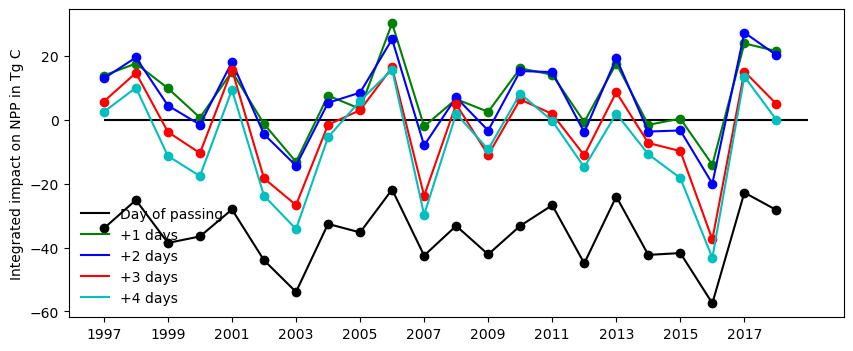

Mean day of passing: -35.84905859964152
SUM of all time_strings...


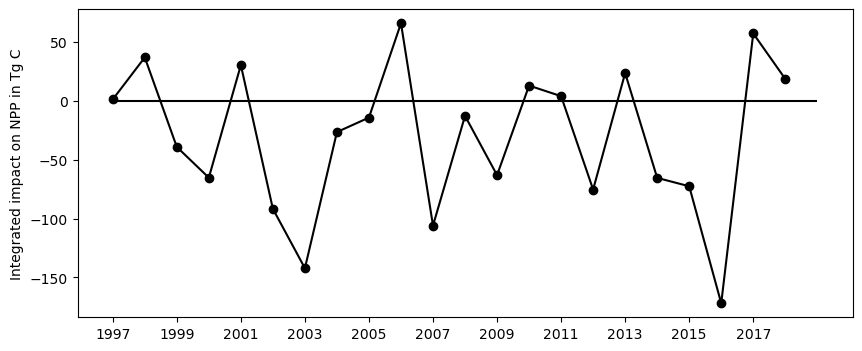

Mean sum of all time strings: -31.595824377682696


In [11]:
#---
# plot NPP anomalies
#---

print('sum_per_year',sum_per_year)

fig=plt.figure(figsize=(10,4))
plt.hlines(0,0,len(years),'k')
plt.plot(sum_per_year,'k',label='Day of passing')
plt.plot(sum_per_year,'ko')
plt.plot(sum_per_year_plus_1,'g',label='+1 days')
plt.plot(sum_per_year_plus_1,'go')
plt.plot(sum_per_year_plus_2,'b',label='+2 days')
plt.plot(sum_per_year_plus_2,'bo')
plt.plot(sum_per_year_plus_3,'r',label='+3 days')
plt.plot(sum_per_year_plus_3,'ro')
plt.plot(sum_per_year_plus_4,'c',label='+4 days')
plt.plot(sum_per_year_plus_4,'co')
plt.ylabel('Integrated impact on NPP in Tg C')
plt.xticks(np.arange(0,len(years),2),years[::2])
plt.legend(frameon=False)
plt.show()

print('Mean day of passing:',np.mean(sum_per_year))


# SUM OF BOTH TIME_STRING
print('SUM of all time_strings...')
fig=plt.figure(figsize=(10,4))
plt.hlines(0,0,len(years),'k')
plt.plot(sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4,'k')
plt.plot(sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4,'ko')
plt.ylabel('Integrated impact on NPP in Tg C')
plt.xticks(np.arange(0,len(years),2),years[::2])
plt.show()

print('Mean sum of all time strings:',\
      np.mean(sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4))

# 
# How does the sum compare to background NPP?
#   For that, sum up background NPP over the same days/locations


sum_per_year [-33.96908902 -25.0967524  -38.532314   -36.50307645 -28.04215605
 -43.9581415  -53.88900744 -32.57132908 -35.24674273 -21.80239476
 -42.49317955 -33.18447703 -42.1270909  -33.18661765 -26.71370914
 -44.92722828 -24.00922496 -42.28675284 -41.70898731 -57.44102755
 -22.76419183 -28.22579872]


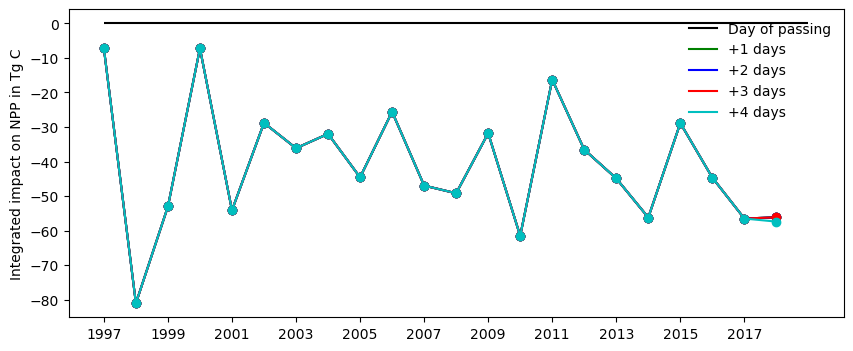

SUM of all time_strings...


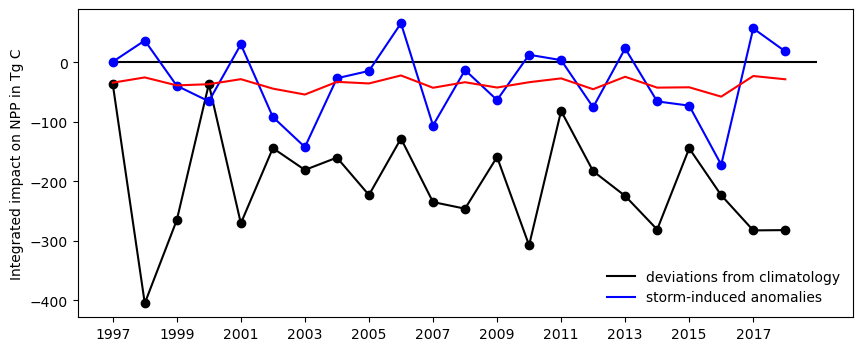

RATIO of SUM of all time_strings...
MEAN ratio in % over all years: 23.614371770273202
MEDIAN ratio in % over all years: 10.576986301215744


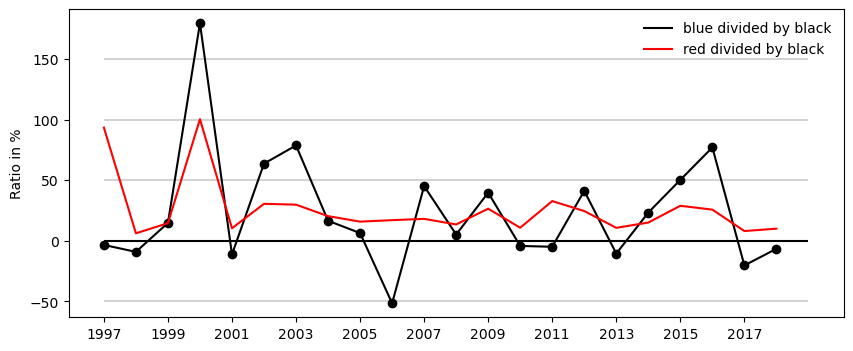

Min black line: -51.54595896713535
Max black line: 179.48557558094532
Mean black line: 23.614371770273202

Mean red line: 25.5973542137117


In [12]:
#---
# plot NPP deviations from clim
#---

print('sum_per_year',sum_per_year)

# each day of the time shift is the same because I always subtract the same clim. 
# +4 days is slightly different in the last year because one storm is missing!
fig=plt.figure(figsize=(10,4))
plt.hlines(0,0,len(years),'k')
plt.plot(sum_per_year_dev,'k',label='Day of passing')
plt.plot(sum_per_year_dev,'ko')
plt.plot(sum_per_year_dev_plus_1,'g',label='+1 days')
plt.plot(sum_per_year_dev_plus_1,'go')
plt.plot(sum_per_year_dev_plus_2,'b',label='+2 days')
plt.plot(sum_per_year_dev_plus_2,'bo')
plt.plot(sum_per_year_dev_plus_3,'r',label='+3 days')
plt.plot(sum_per_year_dev_plus_3,'ro')
plt.plot(sum_per_year_dev_plus_4,'c',label='+4 days')
plt.plot(sum_per_year_dev_plus_4,'co')
plt.ylabel('Integrated impact on NPP in Tg C')
plt.xticks(np.arange(0,len(years),2),years[::2])
plt.legend(frameon=False)
plt.show()

# SUM OF BOTH TIME_STRING
print('SUM of all time_strings...')
fig=plt.figure(figsize=(10,4))
plt.hlines(0,0,len(years),'k')
plt.plot(sum_per_year_dev+sum_per_year_dev_plus_1+sum_per_year_dev_plus_2+sum_per_year_dev_plus_3+sum_per_year_dev_plus_4,'k',label='deviations from climatology')
plt.plot(sum_per_year_dev+sum_per_year_dev_plus_1+sum_per_year_dev_plus_2+sum_per_year_dev_plus_3+sum_per_year_dev_plus_4,'ko')
plt.plot(sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4,'b',label='storm-induced anomalies')
plt.plot(sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4,'bo')
plt.plot(sum_per_year,'r')#,label='Day of passing')
plt.ylabel('Integrated impact on NPP in Tg C')
plt.xticks(np.arange(0,len(years),2),years[::2])
plt.legend(frameon=False)
plt.show()


# RAtio of SUM OF BOTH TIME_STRING

aux1 = sum_per_year_dev+sum_per_year_dev_plus_1+sum_per_year_dev_plus_2+sum_per_year_dev_plus_3+sum_per_year_dev_plus_4
aux2 = sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4
print('RATIO of SUM of all time_strings...')
print('MEAN ratio in % over all years:',np.mean(100*aux2/aux1))
print('MEDIAN ratio in % over all years:',np.median(100*aux2/aux1))

fig=plt.figure(figsize=(10,4))
plt.hlines(0,0,len(years),'k')
plt.hlines(-50,0,len(years),'lightgrey')
plt.hlines(50,0,len(years),'lightgrey')
plt.hlines(100,0,len(years),'lightgrey')
plt.hlines(150,0,len(years),'lightgrey')
plt.plot(100*aux2/aux1,'k',label='blue divided by black')
plt.plot(100*aux2/aux1,'ko')
plt.plot(100*sum_per_year/aux1,'r',label='red divided by black')
plt.ylabel('Ratio in %')
plt.xticks(np.arange(0,len(years),2),years[::2])
plt.legend(frameon=False)
plt.show()

print('Min black line:',np.min(100*aux2/aux1))
print('Max black line:',np.max(100*aux2/aux1))
print('Mean black line:',np.mean(100*aux2/aux1))

print()
print('Mean red line:',np.mean(100*sum_per_year/aux1))

# 
# How does the sum compare to background NPP?
#   For that, sum up background NPP over the same days/locations

# why are deviations from climatology negative for all years???



SUM of all time_strings...


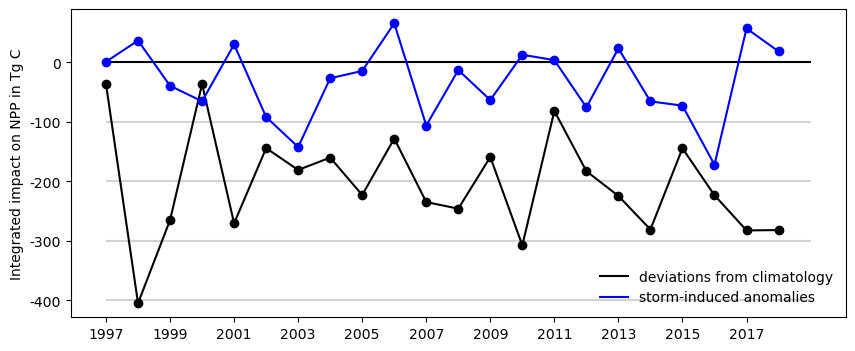

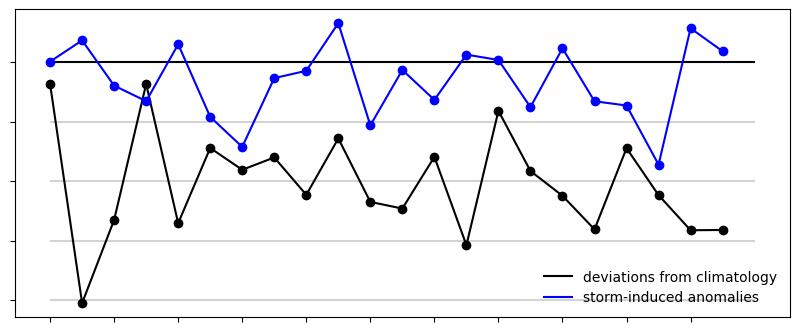

RATIO of SUM of all time_strings...
MEAN ratio in % over all years: 23.614371770273202
MEDIAN ratio in % over all years: 10.576986301215744


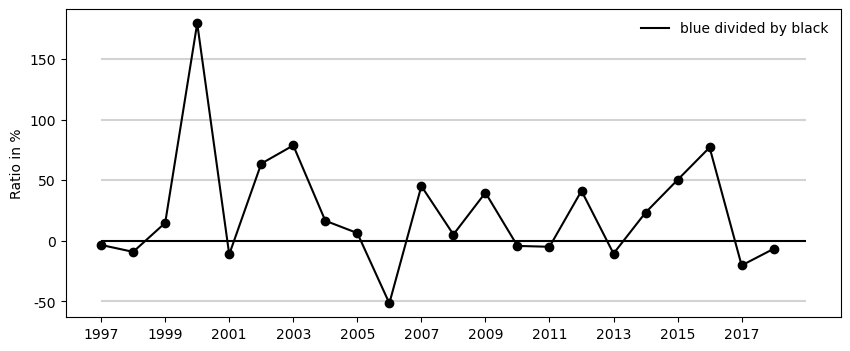

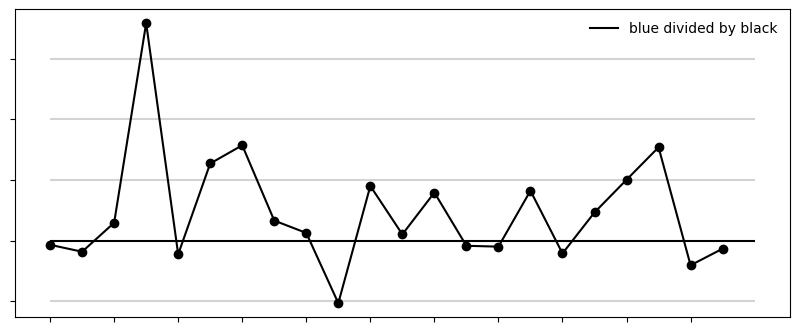

Min black line: -51.54595896713535
Max black line: 179.48557558094532
Mean black line: 23.614371770273202

Mean red line (day of passing only): 25.5973542137117


In [13]:
#---
# FOR PAPER (suplement)
#---
save_plots = True
display_plots = True
plot_eps = True

# SUM OF BOTH TIME_STRING
print('SUM of all time_strings...')
fig=plt.figure(figsize=(10,4))
plt.hlines(0,0,len(years),'k')
plt.hlines(-400,0,len(years),'lightgrey')
plt.hlines(-300,0,len(years),'lightgrey')
plt.hlines(-200,0,len(years),'lightgrey')
plt.hlines(-100,0,len(years),'lightgrey')
plt.plot(sum_per_year_dev+sum_per_year_dev_plus_1+sum_per_year_dev_plus_2+sum_per_year_dev_plus_3+sum_per_year_dev_plus_4,'k',label='deviations from climatology')
plt.plot(sum_per_year_dev+sum_per_year_dev_plus_1+sum_per_year_dev_plus_2+sum_per_year_dev_plus_3+sum_per_year_dev_plus_4,'ko')
plt.plot(sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4,'b',label='storm-induced anomalies')
plt.plot(sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4,'bo')
#plt.plot(sum_per_year,'r')#,label='Day of passing')
plt.ylabel('Integrated impact on NPP in Tg C')
plt.xticks(np.arange(0,len(years),2),years[::2])
plt.yticks([-400,-300,-200,-100,0],[-400,-300,-200,-100,0])
plt.legend(frameon=False)
if save_plots:
    filename = 'Integrated_impact_storms_vert_int_NPP_anomalies_vs_deviations_from_clim.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)

if plot_eps:
    fig=plt.figure(figsize=(10,4))
    plt.hlines(0,0,len(years),'k')
    plt.hlines(-400,0,len(years),'lightgrey')
    plt.hlines(-300,0,len(years),'lightgrey')
    plt.hlines(-200,0,len(years),'lightgrey')
    plt.hlines(-100,0,len(years),'lightgrey')
    plt.plot(sum_per_year_dev+sum_per_year_dev_plus_1+sum_per_year_dev_plus_2+sum_per_year_dev_plus_3+sum_per_year_dev_plus_4,'k',label='deviations from climatology')
    plt.plot(sum_per_year_dev+sum_per_year_dev_plus_1+sum_per_year_dev_plus_2+sum_per_year_dev_plus_3+sum_per_year_dev_plus_4,'ko')
    plt.plot(sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4,'b',label='storm-induced anomalies')
    plt.plot(sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4,'bo')
    #plt.plot(sum_per_year,'r')#,label='Day of passing')
    #plt.ylabel('Integrated impact on NPP in Tg C')
    plt.xticks(np.arange(0,len(years),2),[])
    plt.yticks([-400,-300,-200,-100,0],[])
    plt.legend(frameon=False)
    if save_plots:
        filename = 'Integrated_impact_storms_vert_int_NPP_anomalies_vs_deviations_from_clim.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
    
    
# RAtio of SUM OF BOTH TIME_STRING

aux1 = sum_per_year_dev+sum_per_year_dev_plus_1+sum_per_year_dev_plus_2+sum_per_year_dev_plus_3+sum_per_year_dev_plus_4
aux2 = sum_per_year+sum_per_year_plus_1+sum_per_year_plus_2+sum_per_year_plus_3+sum_per_year_plus_4
print('RATIO of SUM of all time_strings...')
print('MEAN ratio in % over all years:',np.mean(100*aux2/aux1))
print('MEDIAN ratio in % over all years:',np.median(100*aux2/aux1))

fig=plt.figure(figsize=(10,4))
plt.hlines(0,0,len(years),'k')
plt.hlines(-50,0,len(years),'lightgrey')
plt.hlines(50,0,len(years),'lightgrey')
plt.hlines(100,0,len(years),'lightgrey')
plt.hlines(150,0,len(years),'lightgrey')
plt.plot(100*aux2/aux1,'k',label='blue divided by black')
plt.plot(100*aux2/aux1,'ko')
#plt.plot(100*sum_per_year/aux1,'r',label='red divided by black')
plt.ylabel('Ratio in %')
plt.xticks(np.arange(0,len(years),2),years[::2])
plt.yticks([-50,0,50,100,150],[-50,0,50,100,150])
plt.legend(frameon=False)
if save_plots:
    filename = 'Integrated_impact_storms_vert_int_NPP_RATIO_anomalies_vs_deviations_from_clim.png'
    plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
if display_plots:
    plt.show()
else:
    plt.close(fig)
    
if plot_eps:
    fig=plt.figure(figsize=(10,4))
    plt.hlines(0,0,len(years),'k')
    plt.hlines(-50,0,len(years),'lightgrey')
    plt.hlines(50,0,len(years),'lightgrey')
    plt.hlines(100,0,len(years),'lightgrey')
    plt.hlines(150,0,len(years),'lightgrey')
    plt.plot(100*aux2/aux1,'k',label='blue divided by black')
    plt.plot(100*aux2/aux1,'ko')
    #plt.plot(100*sum_per_year/aux1,'r',label='red divided by black')
    #plt.ylabel('Ratio in %')
    plt.xticks(np.arange(0,len(years),2),[])
    plt.yticks([-50,0,50,100,150],[])
    plt.legend(frameon=False)
    if save_plots:
        filename = 'Integrated_impact_storms_vert_int_NPP_RATIO_anomalies_vs_deviations_from_clim.eps'
        plt.savefig(savepath2+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

print('Min black line:',np.min(100*aux2/aux1))
print('Max black line:',np.max(100*aux2/aux1))
print('Mean black line:',np.mean(100*aux2/aux1))

print()
print('Mean red line (day of passing only):',np.mean(100*sum_per_year/aux1))



sum_per_year_abs [1283.27345311  995.01641955 1021.17737943 1163.19576107 1001.72851919
 1140.60323634 1155.23218018 1095.47025525 1239.6238204  1143.80913129
 1112.89079272 1038.69623487 1164.47978967 1132.29214989 1157.72984245
 1301.31291526 1226.98433621 1133.52175922 1072.4840315  1253.93604174
 1148.19838645 1141.24145315]


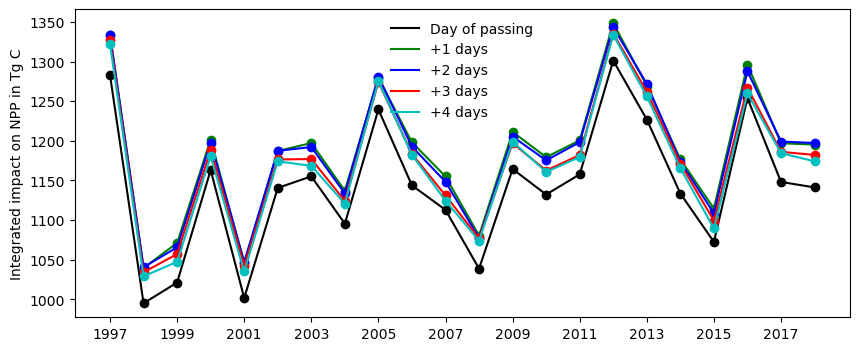

SUM of all time_strings...


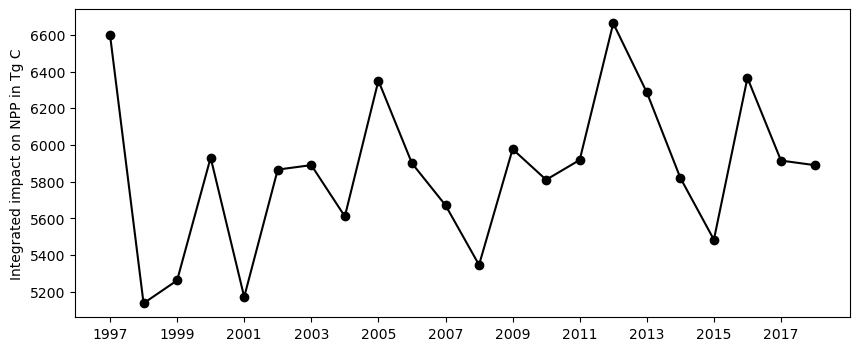

In [14]:
#---
# plot abs NPP 
#---

print('sum_per_year_abs',sum_per_year_abs)

fig=plt.figure(figsize=(10,4))
plt.plot(sum_per_year_abs,'k',label='Day of passing')
plt.plot(sum_per_year_abs,'ko')
plt.plot(sum_per_year_abs_plus_1,'g',label='+1 days')
plt.plot(sum_per_year_abs_plus_1,'go')
plt.plot(sum_per_year_abs_plus_2,'b',label='+2 days')
plt.plot(sum_per_year_abs_plus_2,'bo')
plt.plot(sum_per_year_abs_plus_3,'r',label='+3 days')
plt.plot(sum_per_year_abs_plus_3,'ro')
plt.plot(sum_per_year_abs_plus_4,'c',label='+4 days')
plt.plot(sum_per_year_abs_plus_4,'co')
plt.ylabel('Integrated impact on NPP in Tg C')
plt.xticks(np.arange(0,len(years),2),years[::2])
plt.legend(frameon=False)
plt.show()

# SUM OF BOTH TIME_STRING
print('SUM of all time_strings...')
fig=plt.figure(figsize=(10,4))
#plt.hlines(0,0,len(years),'k')
plt.plot(sum_per_year_abs+sum_per_year_abs_plus_1+sum_per_year_abs_plus_2+sum_per_year_abs_plus_3+sum_per_year_abs_plus_4,'k')
plt.plot(sum_per_year_abs+sum_per_year_abs_plus_1+sum_per_year_abs_plus_2+sum_per_year_abs_plus_3+sum_per_year_abs_plus_4,'ko')
plt.ylabel('Integrated impact on NPP in Tg C')
plt.xticks(np.arange(0,len(years),2),years[::2])
plt.show()

# 
# How does the sum compare to background NPP?
#   For that, sum up background NPP over the same days/locations
